In [9]:
ENV["JULIA_PKG_SERVER"] = ""

using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using MLJBase: machine, transform
using TableTransforms
using Imbalance

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


### 1. Generate Random Data

In [10]:
rng = Random.default_rng()

type="ColTable"
num_rows = 90
num_features = 2
class_probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(num_rows, num_features; min_sep=0.1, class_probs, type, insert_y=y_ind, rng=39)
X, y = generate_imbalanced_data(num_rows, num_features; min_sep=0.1, class_probs, type, rng=39)

((Column1 = [0.3099516401399159, 0.9495309447472282, 0.8531752071798575, 0.9065952954990415, 0.268889786011594, 0.32919764403787244, 0.85961435523993, 0.8048053380258109, 0.7023995986031453, 0.779731597417754  …  0.7791112680368545, 0.6923043238711727, 0.9444262704690506, 0.8514032063784466, 0.09757374470845759, 0.9915404284184693, 0.40313106114343855, 0.44579866274089824, 0.13119759922002655, 0.9193781611227215], Column2 = [0.3785579494478395, 0.10972285478056198, 0.400750892229322, 0.4557078459444602, 0.6279035280894512, -0.13323360081444913, 0.8069262979340133, 0.5252307614464421, 0.18310986909449145, 0.42493596859060645  …  0.24210950213234397, 0.986582730979072, 0.7524099367924534, 0.3333523360147486, 0.5900536608411613, 1.2732598324845843, 0.4613469107614757, 0.239638772630316, 0.4383396230770452, 0.8851853636458944]), CategoricalValue{Int64, UInt32}[1, 0, 0, 0, 2, 2, 0, 0, 2, 2  …  2, 0, 0, 0, 1, 0, 1, 2, 1, 0])

### 2. Apply Tomek Undersampler

#### Using Imbalance Only

In [11]:
X_under, y_under = tomek_undersample(X, y; min_ratios = 0.01, rng = 42)
checkbalance(y_under)

2: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 11 (27.5%) 
1: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 17 (42.5%) 
0: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 40 (100.0%) 


#### Using MLJ

In [12]:
naive_model = Imbalance.MLJ.TomekUndersampler(min_ratios=Dict(0=>1.0, 1=> 1.0, 2=>0.9), rng=42)
mach = machine(naive_model)
X_under, y_under = transform(mach, X, y)

((Column1 = [0.3099516401399159, 0.8693715214135129, -0.13225248069014212, 0.35823154943190527, -0.1344312948537884, 0.12401783892965668, 0.8424497239833251, 0.1791853436621728, 0.1507755760631508, 0.3110346219365628  …  1.189224578775524, 0.6154447193853916, 0.8248018854901781, 0.34397888156560336, 0.9231027290620563, 0.4980233007900128, 0.5977387027993966, 0.5461560044311679, 1.109197196705519, 0.44579866274089824], Column2 = [0.3785579494478395, 0.2832896320631536, 0.4627379130519581, 0.31883504777021, 0.37289223658450676, 0.5719557969812568, 0.8792047292928311, 0.3664375461537489, 0.22833989091874257, 0.4769442373342253  …  0.4487485976572063, 0.2133889518091821, 0.23163870519360724, 0.35991675000740225, -0.03457384792571938, 0.5575132620705916, 0.7824619283126578, 0.6635020091518017, 0.4069015220629007, 0.239638772630316]), Any[CategoricalValue{Int64, UInt32} 1, CategoricalValue{Int64, UInt32} 1, CategoricalValue{Int64, UInt32} 1, CategoricalValue{Int64, UInt32} 1, CategoricalValu

#### Using TableTransforms

In [13]:
using Imbalance: TableTransforms.TomekUndersampler
naive_model_t = TomekUndersampler(y_ind, min_ratios=Dict(0=>1.0, 1=> 0.9, 2=>1.0), rng=42)
Xyover = Xy |> naive_model_t

(Column1 = [0.19594587594420074, 0.4115892807608941, 0.4512483556559736, 0.5945965545252668, 0.34958922983979573, 0.37167695755070695, 0.2308326117090886, 0.49602693589469904, 0.12235758893373405, 0.4975503415503491  …  0.6180436151385241, 0.784750964834851, 0.6217623551177751, 0.6176968479935476, 0.8830196260301688, 1.0554353973262307, 0.6910586610529916, 0.46736377765306897, 1.0357919301612297, 0.8223429633777958],
 Column2 = [0.37853884723812026, 0.3153410783626698, 0.5058857777328364, 0.3793602449415098, 0.31230709418910096, 0.4973320896595887, 0.34517232839057055, 0.5427694818226043, 0.5301416408428289, 0.5347519693064301  …  0.49474854169680804, 0.20942146643684634, 0.909186742322861, 0.3493048541742634, 0.8308554679954137, 0.10581494500307381, 0.3843063716614653, 0.20834963626982406, 0.5039555300434245, 0.4433115056878822],
 Column3 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],)

### 3. Plot the Results

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


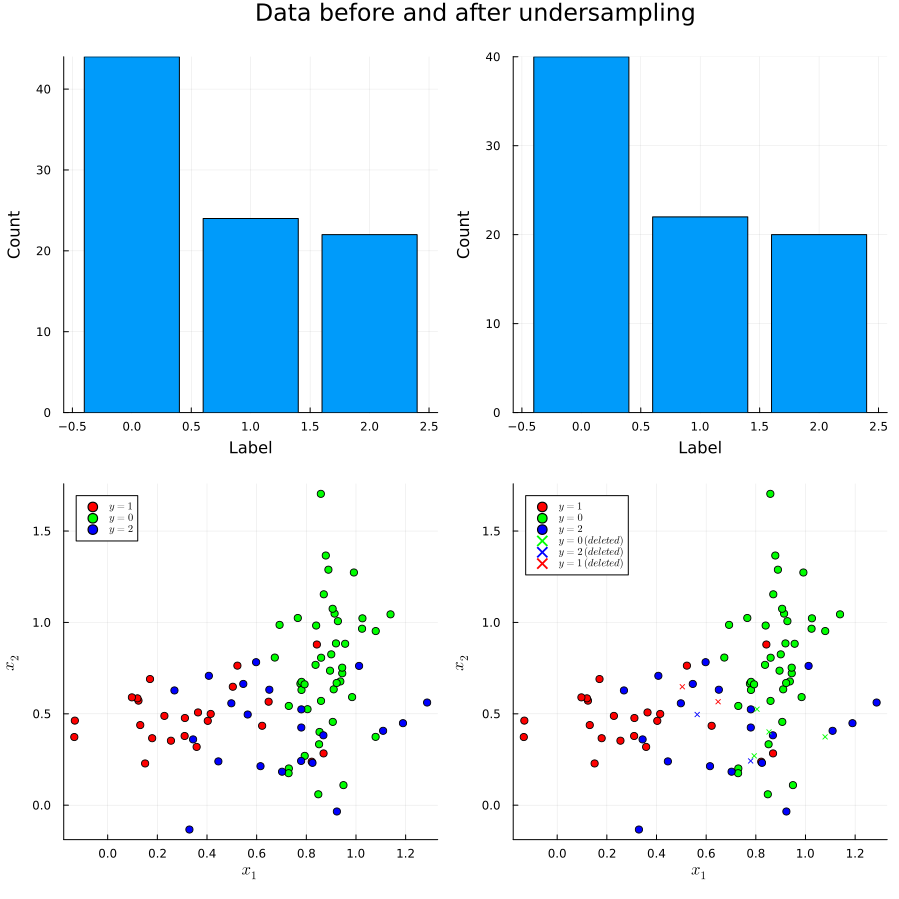

In [14]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, y_under, X, X_under)